In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the Dataset

In [12]:
dataset = pd.read_excel('final_dataset.xlsx')

# 결측치 처리

### - 해당 데이터셋은 국가 통계 포털인 KOSIS로부터 가져온 데이터이기 때문에 결측치가 존재하지 않음
### - 따라서 결측치를 무작위로 생성

In [13]:
# 항상 같은 결과가 나오도록 시드를 고정
np.random.seed(42)
# 결측치 비율을 전체 데이터의 1%로 설정
missing_rate = 0.01

# 전체 셀 개수 계산
tot_cells = dataset.size
num_missing = int(tot_cells * missing_rate)


# 무작위 (행, 열) 인덱스 생성
rows = np.random.randint(0, dataset.shape[0], num_missing)
cols = np.random.randint(0, dataset.shape[1], num_missing)

# 무작위 위치에 결측치 삽입
for row, col in zip(rows, cols):
    dataset.iat[row, col] = np.nan

# 결측치를 삽입한 데이터셋을 csv파일로 만들어 내보내기.
dataset.to_csv('missing_value_household.csv')

# 각 열마다 결측치의 개수 세어주는 코드.
print(dataset.isnull().sum())

조사연월                       112
가구구분코드                     121
가구원수                       132
취업인원수                      137
노인가구여부                     122
가구주_연령                     131
가구주_학력코드                   112
가구주_취업여부                   140
가구주_10차산업분류코드              118
거처구분코드                     128
입주형태코드                     143
전국전체가구_1인이상소득10분위코드        129
소득구간코드                     162
가계지출금액                     116
가계지출_소비지출금액                154
가계지출_소비지출_식료품비주류음료구입비      126
가계지출_소비지출_주류담배구입비          162
가계지출_소비지출_의류신발구입비          119
가계지출_소비지출_주거수도광열비          132
가계지출_소비지출_가정용품가사서비스이용금액    131
가계지출_소비지출_보건제품구입비          124
가계지출_소비지출_교통비              165
가계지출_소비지출_통신비              143
가계지출_소비지출_오락문화비            124
가계지출_소비지출_교육비              136
가계지출_소비지출_음식숙박비            139
가계지출_소비지출_기타상품서비스이용금액      149
도시읍면부구분코드                  142
dtype: int64


### - 각 열마다 결측치를 처리
### - 이미 완벽하게 정렬된 데이터이기 때문에 결측치를 바로 앞의 행 값으로 처리

In [14]:
# 조사연월은 다른 행의 값과 똑같이 처리(202400으로)
dataset['조사연월'] = dataset['조사연월'].fillna(202400)

# 가구구분코드 
dataset['가구구분코드'] = dataset['가구구분코드'].ffill()

# 가구원수
dataset['가구원수'] = dataset['가구원수'].ffill()

# 취업인원수
dataset['취업인원수'] = dataset['취업인원수'].ffill()

# 가구주연령 (노인가구여부 다음 열이긴 하지만 이걸 먼저 채워야 노인가구여부를 채울 수 있음)
dataset['가구주_연령'] = dataset['가구주_연령'].ffill()

# 노인가구여부 가구주_연령이 65세 이상인 경우 노인가구여부를 1로 설정
dataset.loc[dataset['가구주_연령'] >= 65, '노인가구여부'] = 1
# 나머지 NaN인 노인가구여부는 0으로 채움
dataset['노인가구여부'] = dataset['노인가구여부'].fillna(0)

# 가구주_학력코드
dataset['가구주_학력코드'] = dataset['가구주_학력코드'].ffill()

# 가구주_취업여부
dataset['가구주_취업여부'] = dataset['가구주_취업여부'].ffill()

# 가구주_10차산업분류코드
dataset['가구주_10차산업분류코드'] = dataset['가구주_10차산업분류코드'].ffill()

# 거처구분코드
dataset['거처구분코드'] = dataset['거처구분코드'].ffill()

# 입주형태코드
dataset['입주형태코드'] = dataset['입주형태코드'].ffill()

# 12개의 소비품목, 가계지출_소비지출금액 결측치 채워넣기
# 소비지출 항목 12개
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

total_column = '가계지출_소비지출금액'

# 평균값들 미리 계산
group_item_mean = dataset.groupby('가구원수')[item_columns].mean()
global_item_mean = dataset[item_columns].mean()

def smart_fill(row):
    items = row[item_columns]
    total = row[total_column]
    size = row['가구원수']

    # 1. 총합이 있고, 일부 항목만 결측 → 남은 금액 균등 분배
    if pd.notna(total) and items.isna().any() and items.notna().sum() > 0:
        known_sum = items.sum(skipna=True)
        remaining = total - known_sum
        missing_count = items.isna().sum()
        if missing_count > 0:
            each = remaining / missing_count
            row[item_columns] = items.fillna(each)

    # 2. 총합이 결측이고, 항목이 모두 채워짐 → 항목 합으로 총합 계산
    elif pd.isna(total) and items.notna().all():
        row[total_column] = items.sum()

    # 3. 총합과 항목 일부가 모두 결측 → 항목은 그룹 평균으로 채우고 총합은 항목합
    elif pd.isna(total) and items.isna().any():
        if size in group_item_mean.index:
            group_mean = group_item_mean.loc[size]
            row[item_columns] = items.fillna(group_mean).fillna(global_item_mean)
        else:
            row[item_columns] = items.fillna(global_item_mean)
        row[total_column] = row[item_columns].sum()

    # 4. 총합은 있지만 항목이 전부 NaN → 12개 항목에 균등 분배
    elif pd.notna(total) and items.isna().all():
        row[item_columns] = [total / len(item_columns)] * len(item_columns)

    return row

# 적용
dataset = dataset.apply(smart_fill, axis=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19284\3336997095.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  row[item_columns] = items.fillna(each)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19284\3336997095.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  row[item_columns] = items.fillna(each)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19284\3336997095.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects

In [15]:
# 가계지출금액 (소비지출 + 비소비지출)
# 1. 소비지출금액이 존재할 경우 → 110%로 보정
def fill_total_expenditure(row):
    if pd.isna(row['가계지출금액']):
        consumption = row['가계지출_소비지출금액']
        size = row['가구원수']

        if pd.notna(consumption):
            # 소비지출에 비소비지출 약간 더한 가정
            return consumption * 1.1

        elif size in dataset.groupby('가구원수')['가계지출금액'].mean():
            return dataset.groupby('가구원수')['가계지출금액'].mean().loc[size]

        else:
            return dataset['가계지출금액'].mean()

    else:
        return row['가계지출금액']

# 적용
dataset['가계지출금액'] = dataset.apply(fill_total_expenditure, axis=1)

In [16]:
# 전국전체가구_1인이상소득10분위코드 (상대적). 다른 feature들 먼저 채우고 나중에 채우기.
# 소득구간코드 (절대적), feature selection 과정에서 drop시킬듯. 다른 feature들 먼저 채우고 나중에 채우기.
# 미리 그룹 평균 계산
group_decile_by_income = dataset.groupby('소득구간코드')['전국전체가구_1인이상소득10분위코드'].mean()
group_income_by_decile = dataset.groupby('전국전체가구_1인이상소득10분위코드')['소득구간코드'].mean()
group_income_by_size = dataset.groupby('가구원수')['소득구간코드'].mean()

# 중앙값 (최후의 fallback)
decile_median = dataset['전국전체가구_1인이상소득10분위코드'].median()
income_median = dataset['소득구간코드'].median()

def fill_income_and_decile(row):
    income = row['소득구간코드']
    decile = row['전국전체가구_1인이상소득10분위코드']
    size = row['가구원수']

    # 1. 소득구간코드가 존재하고 분위가 결측
    if pd.notna(income) and pd.isna(decile):
        if income in group_decile_by_income.index:
            row['전국전체가구_1인이상소득10분위코드'] = round(group_decile_by_income.loc[income])

    # 2. 분위가 존재하고 소득구간이 결측
    elif pd.notna(decile) and pd.isna(income):
        if decile in group_income_by_decile.index:
            row['소득구간코드'] = round(group_income_by_decile.loc[decile])

    # 3. 둘 다 결측
    elif pd.isna(income) and pd.isna(decile):
        # 가구원수 기반으로 소득구간 예측
        if pd.notna(size) and size in group_income_by_size.index:
            row['소득구간코드'] = round(group_income_by_size.loc[size])
        else:
            row['소득구간코드'] = income_median

        # 분위는 보수적으로 중앙값 사용
        row['전국전체가구_1인이상소득10분위코드'] = decile_median

    return row

# 적용
dataset = dataset.apply(fill_income_and_decile, axis=1)

In [17]:
# 도시읍면부구분코드
# 최빈값 계산
mode_city = dataset['도시읍면부구분코드'].mode().iloc[0]
# 결측치 채우기
dataset['도시읍면부구분코드'] = dataset['도시읍면부구분코드'].fillna(mode_city)

# 결측치 처리가 잘 되었는지 확인
print(dataset.isnull().sum())



# EDA 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print(dataset[item_columns].max())

조사연월                       0
가구구분코드                     0
가구원수                       0
취업인원수                      0
노인가구여부                     0
가구주_연령                     0
가구주_학력코드                   0
가구주_취업여부                   0
가구주_10차산업분류코드              0
거처구분코드                     0
입주형태코드                     0
전국전체가구_1인이상소득10분위코드        0
소득구간코드                     0
가계지출금액                     0
가계지출_소비지출금액                0
가계지출_소비지출_식료품비주류음료구입비      0
가계지출_소비지출_주류담배구입비          0
가계지출_소비지출_의류신발구입비          0
가계지출_소비지출_주거수도광열비          0
가계지출_소비지출_가정용품가사서비스이용금액    0
가계지출_소비지출_보건제품구입비          0
가계지출_소비지출_교통비              0
가계지출_소비지출_통신비              0
가계지출_소비지출_오락문화비            0
가계지출_소비지출_교육비              0
가계지출_소비지출_음식숙박비            0
가계지출_소비지출_기타상품서비스이용금액      0
도시읍면부구분코드                  0
dtype: int64
가계지출_소비지출_식료품비주류음료구입비       2236470.0
가계지출_소비지출_주류담배구입비            674620.0
가계지출_소비지출_의류신발구입비           3833847.0
가계지출_소비지출_주거수도광열비          26711138.0
가계지출_소비지출_가정용품가사서비스이용금액

# EDA 진행

In [18]:
# EDA - 한글 폰트 설정
# AppleGothic 폰트는 윈도우에서 사용불가
# https://fonts.google.com/noto/specimen/Noto+Sans+KR
# 해당 웹사이트에서 폰트를 다운받아 사용
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

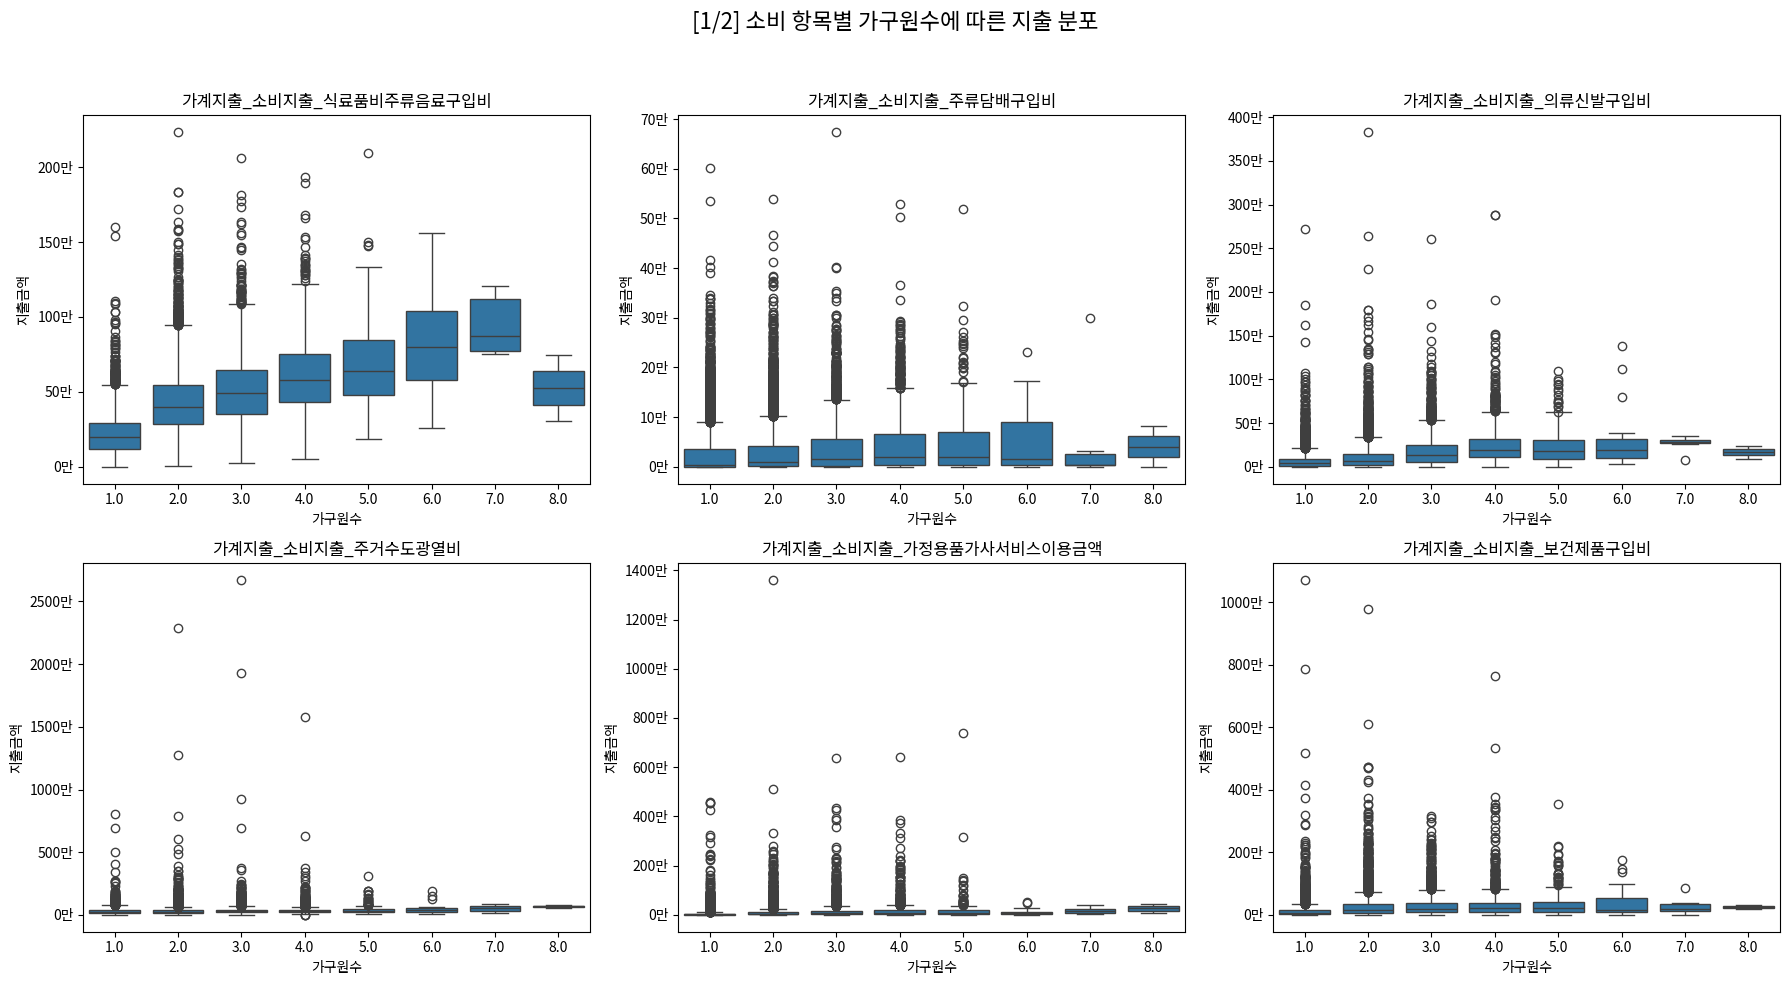

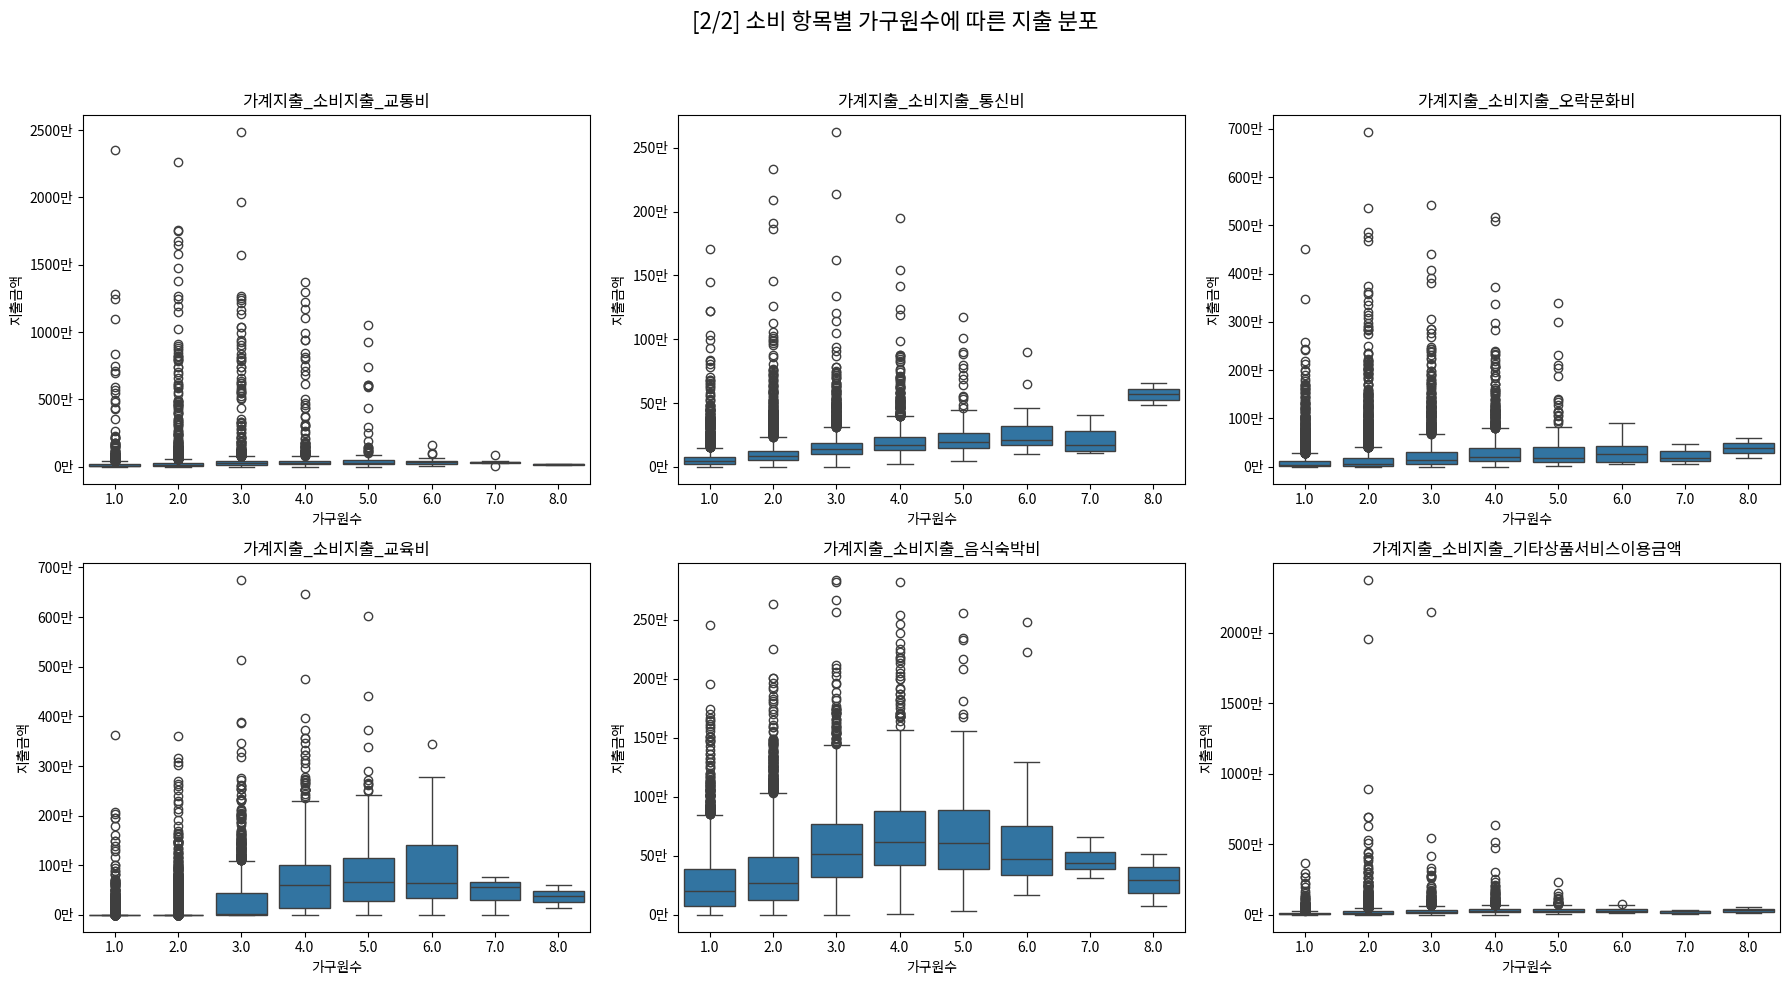

In [19]:
# Boxplot으로 outlier detection

# 첫 번째 6개 항목 (1/2)
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
axes1 = axes1.flatten()

for i, col in enumerate(item_columns[:6]):
    sns.boxplot(data=dataset, x='가구원수', y=col, ax=axes1[i])
    axes1[i].set_title(f"{col}")
    axes1[i].set_xlabel("가구원수")
    axes1[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes1[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[1/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 두 번째 6개 항목 (2/2)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
axes2 = axes2.flatten()

for i, col in enumerate(item_columns[6:]):
    sns.boxplot(data=dataset, x='가구원수', y=col, ax=axes2[i])
    axes2[i].set_title(f"{col}")
    axes2[i].set_xlabel("가구원수")
    axes2[i].set_ylabel("지출금액")
    # 만원 단위로 포맷
    axes2[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))

plt.suptitle("[2/2] 소비 항목별 가구원수에 따른 지출 분포", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

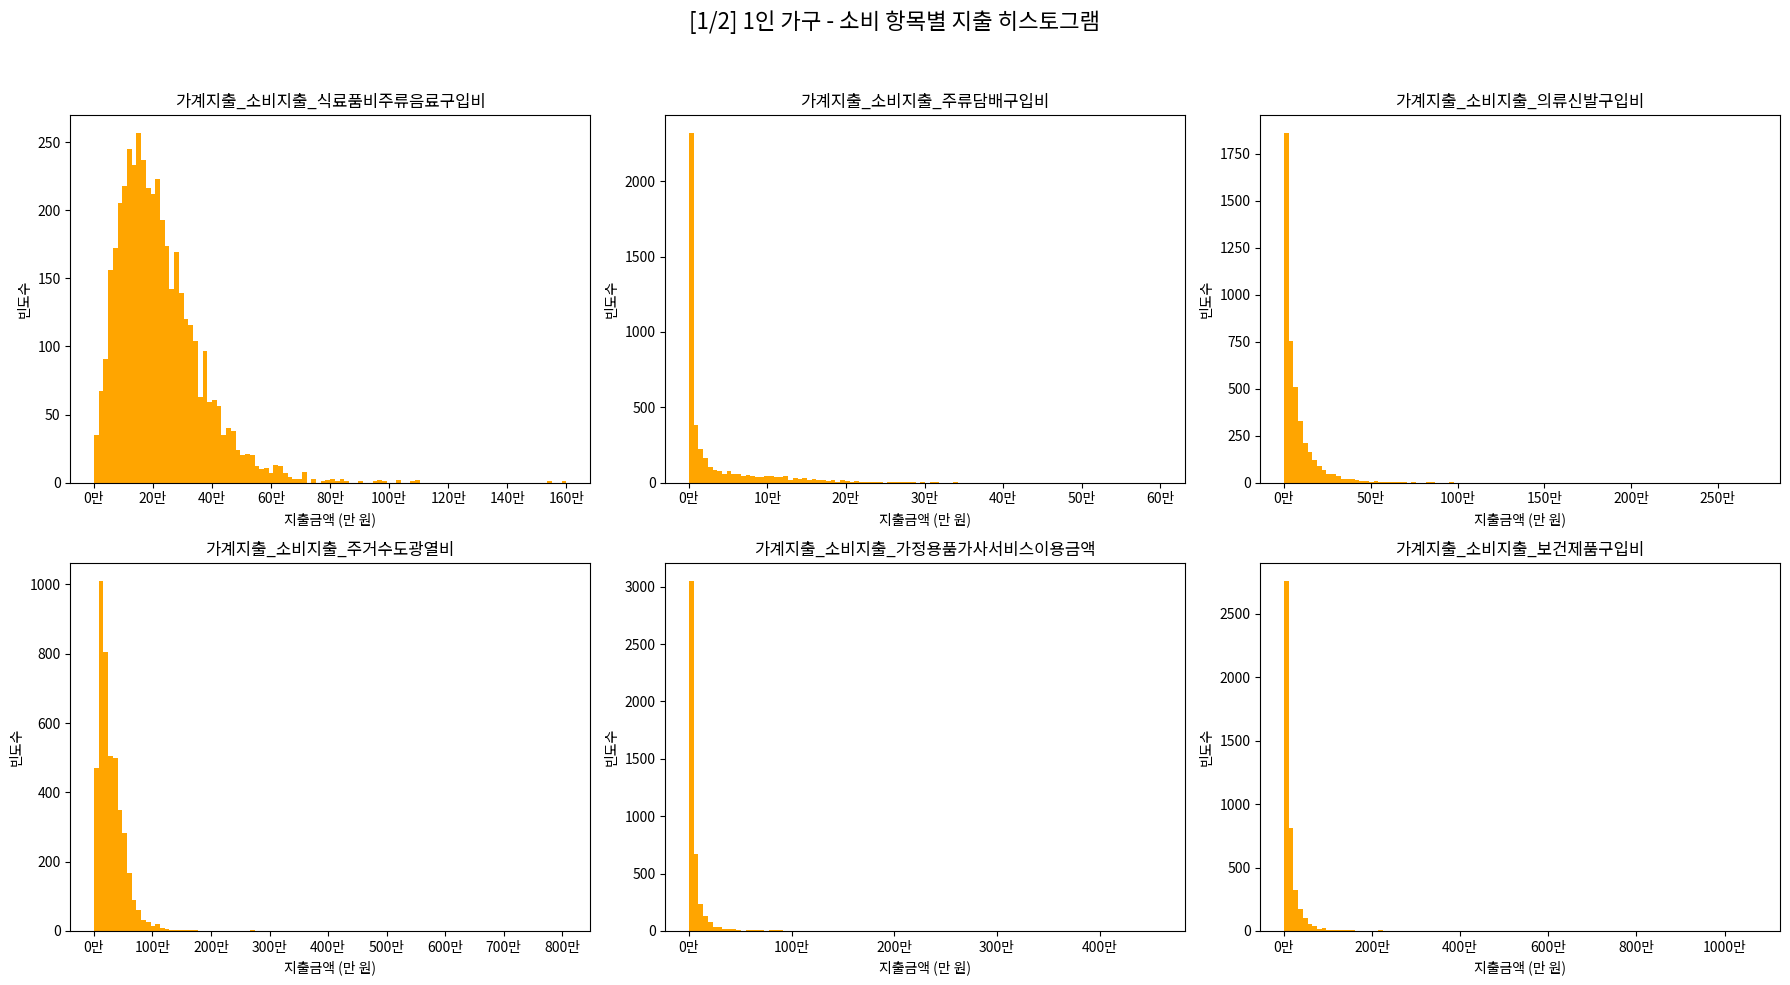

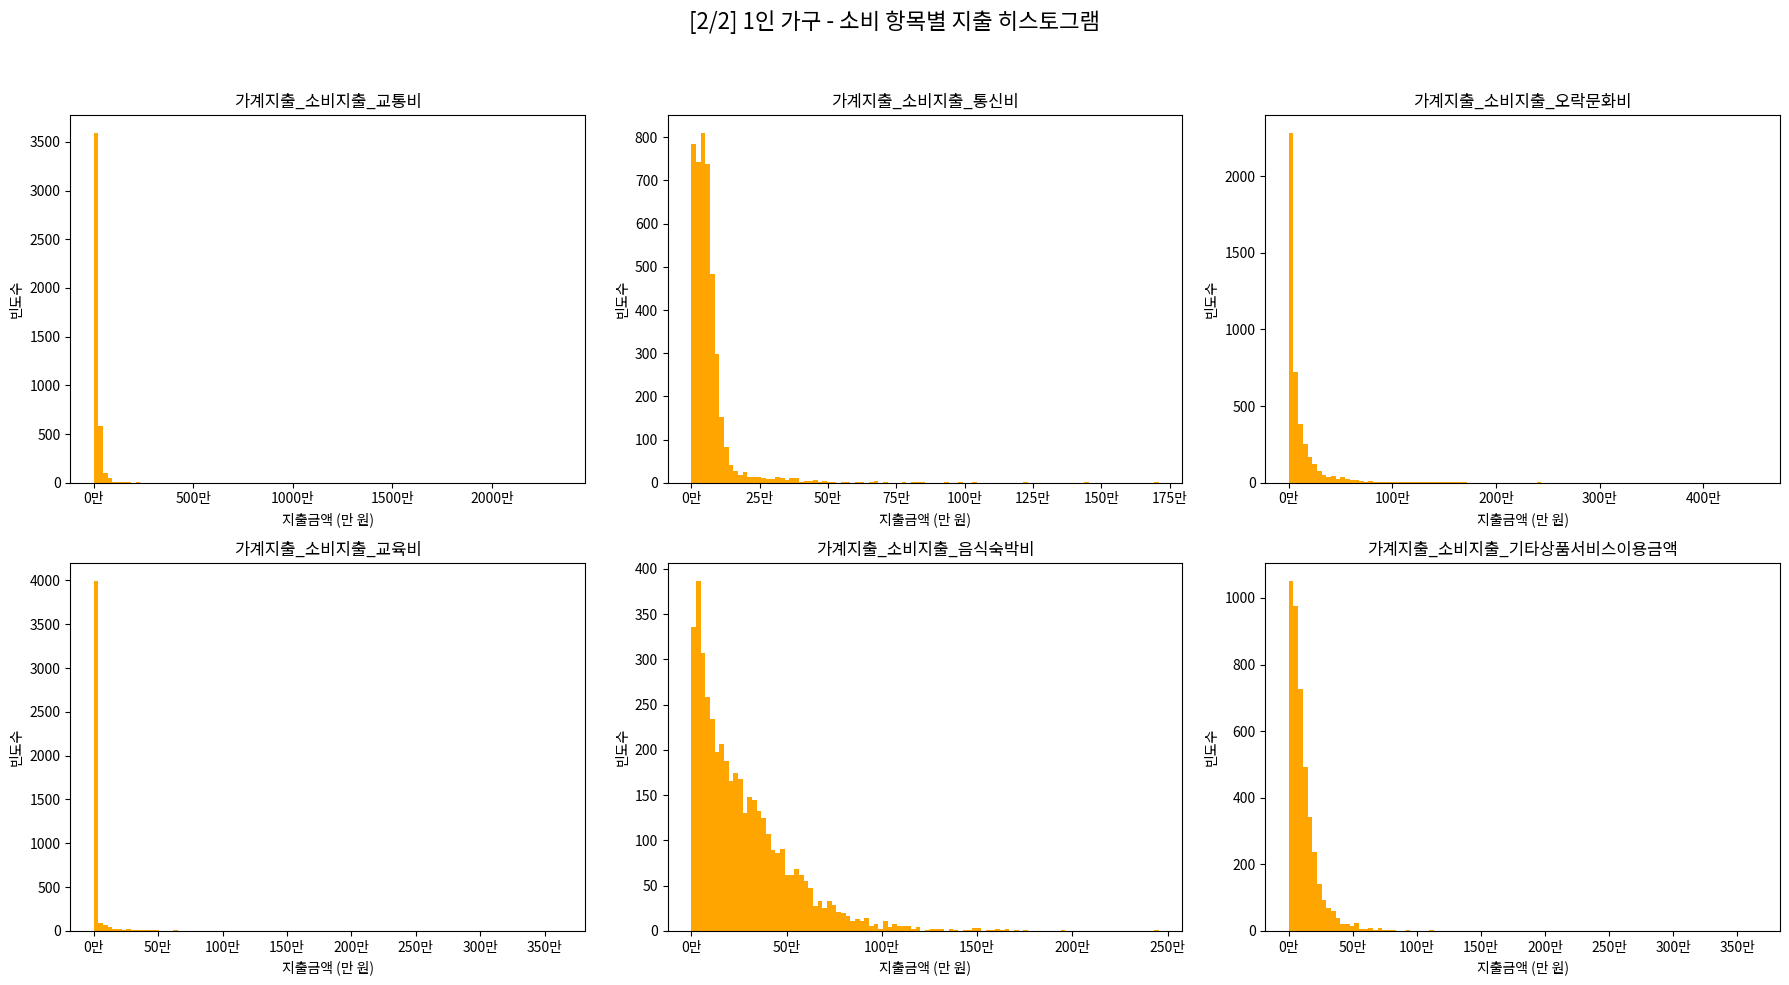

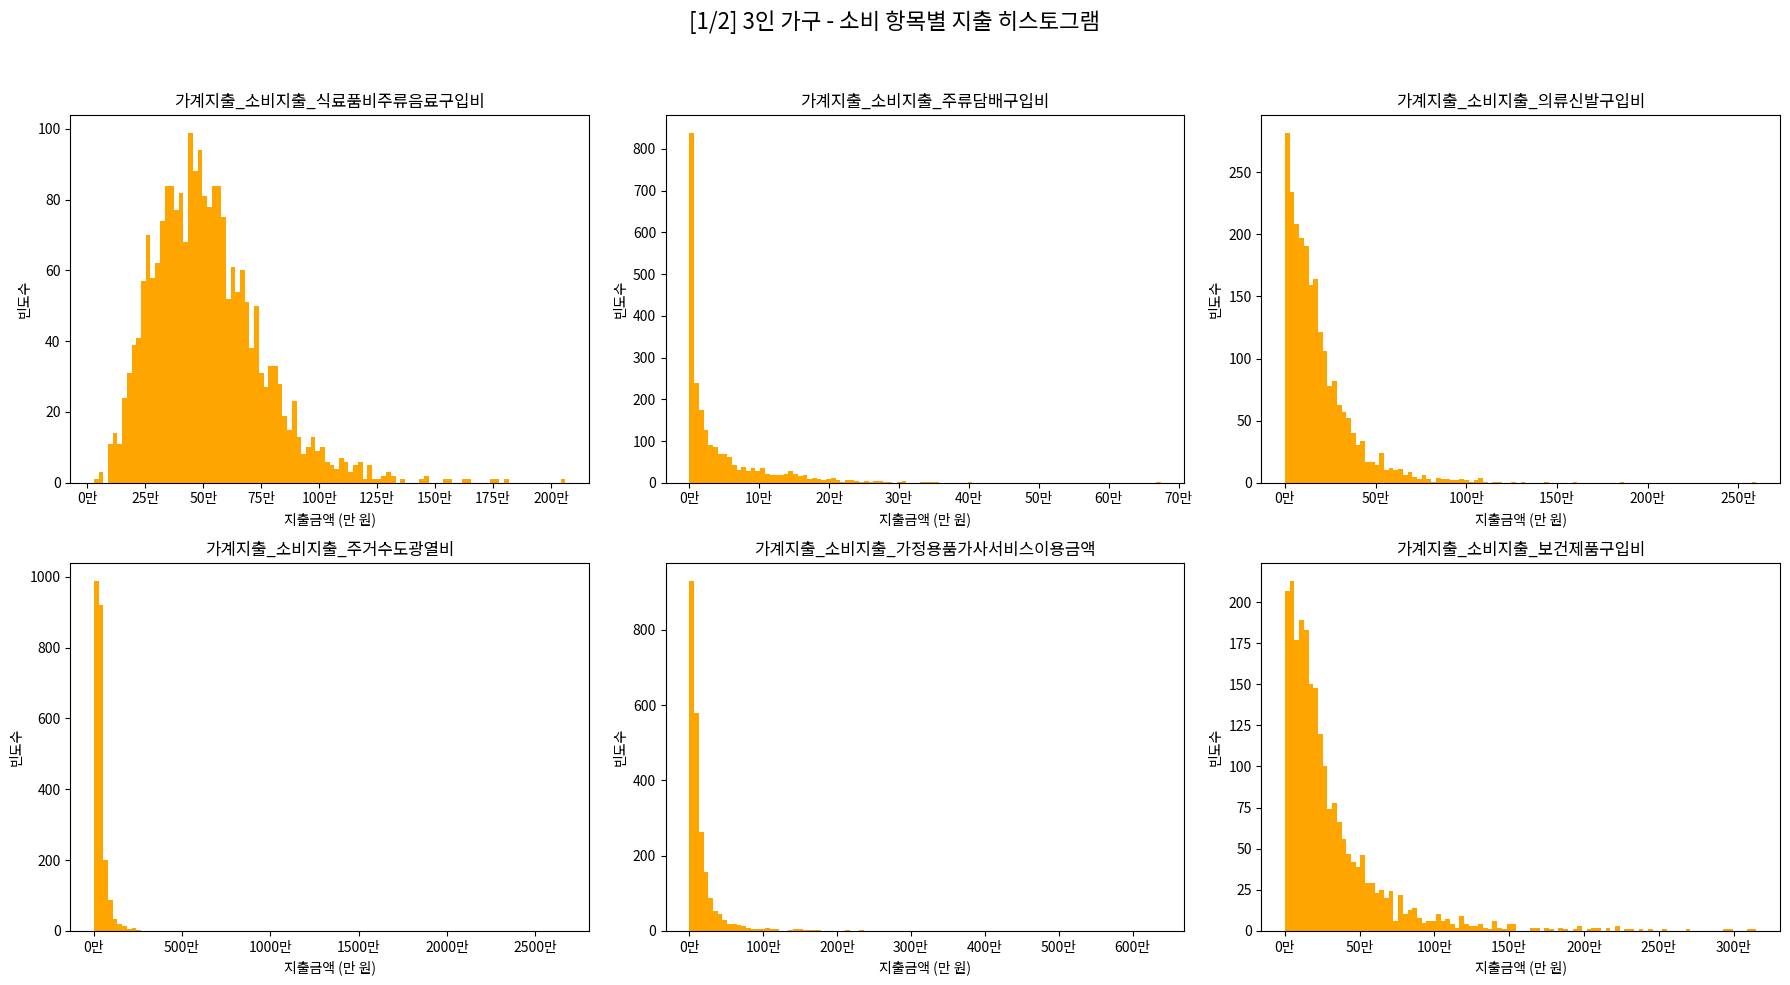

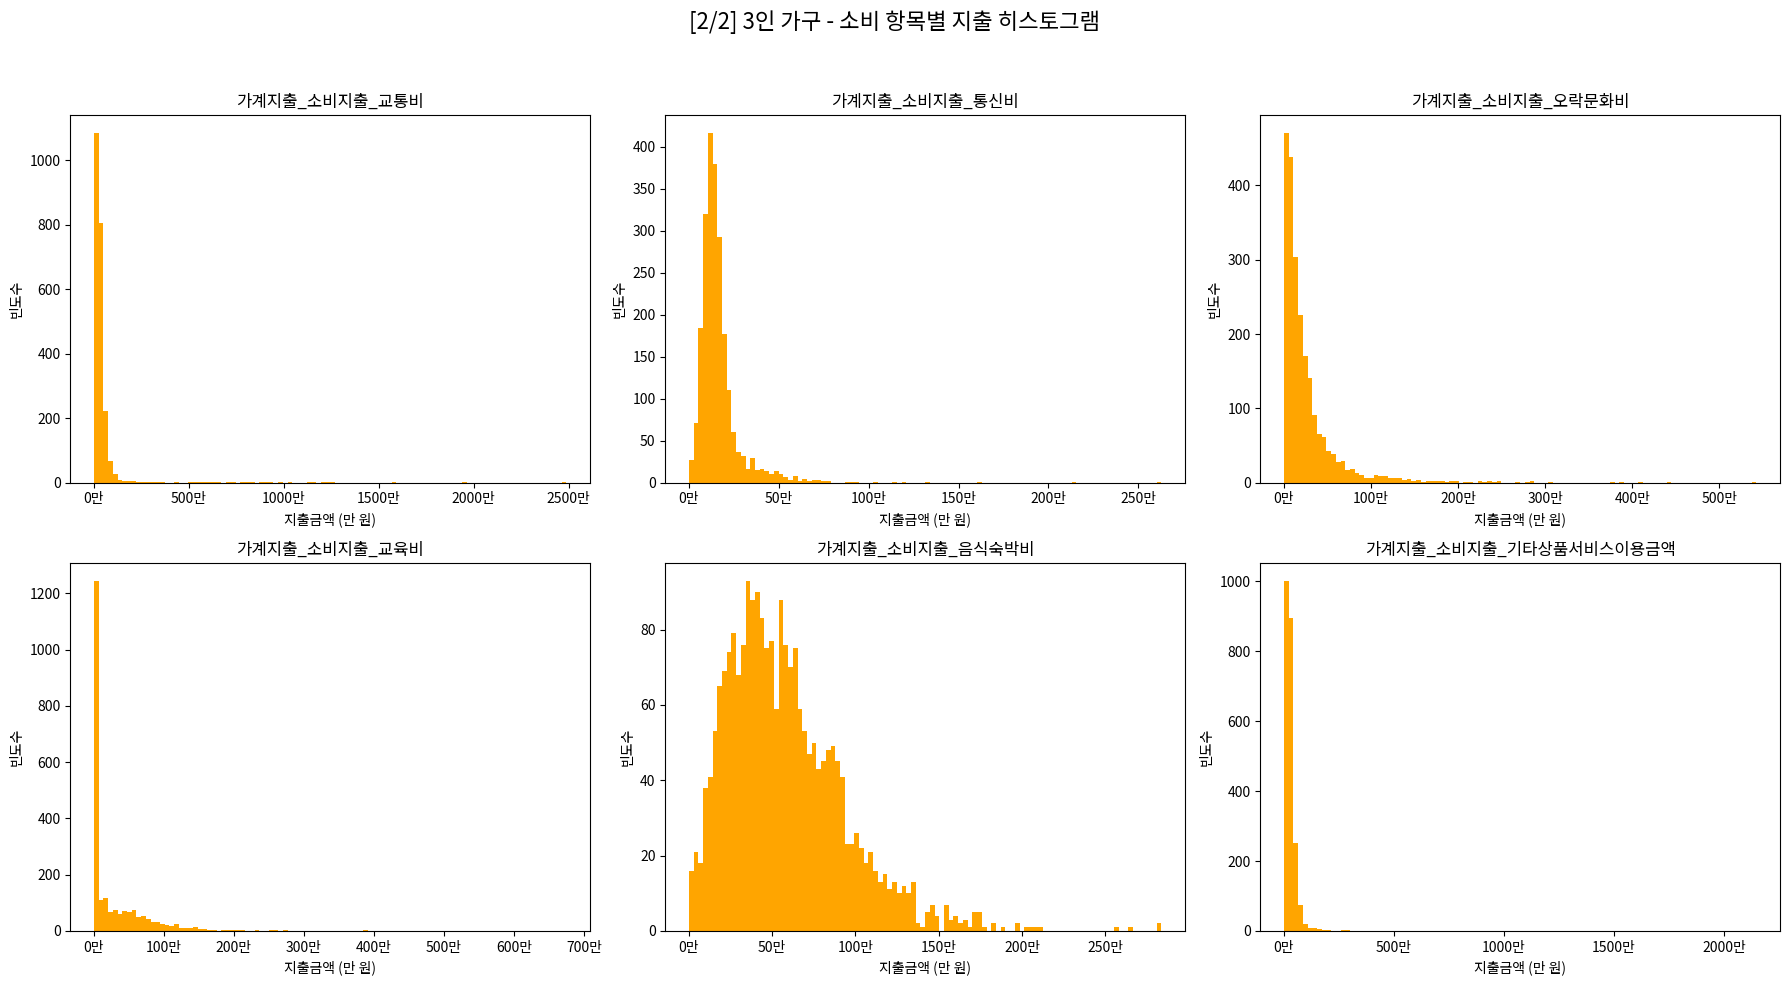

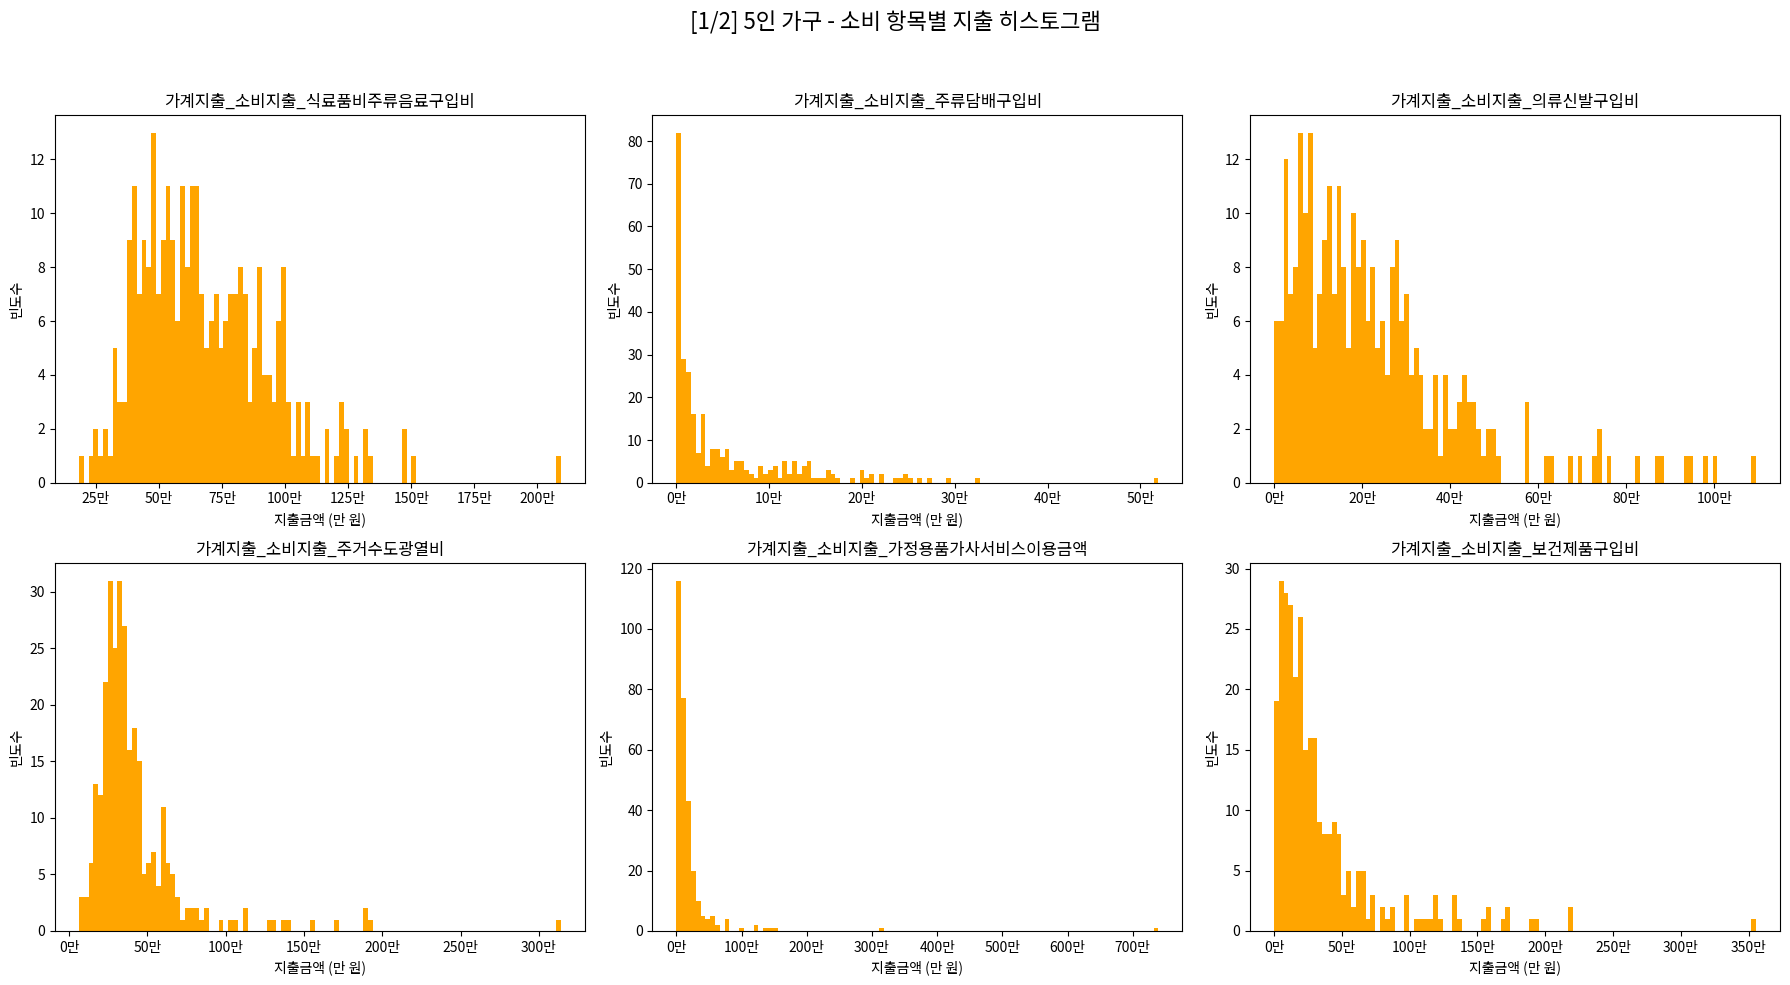

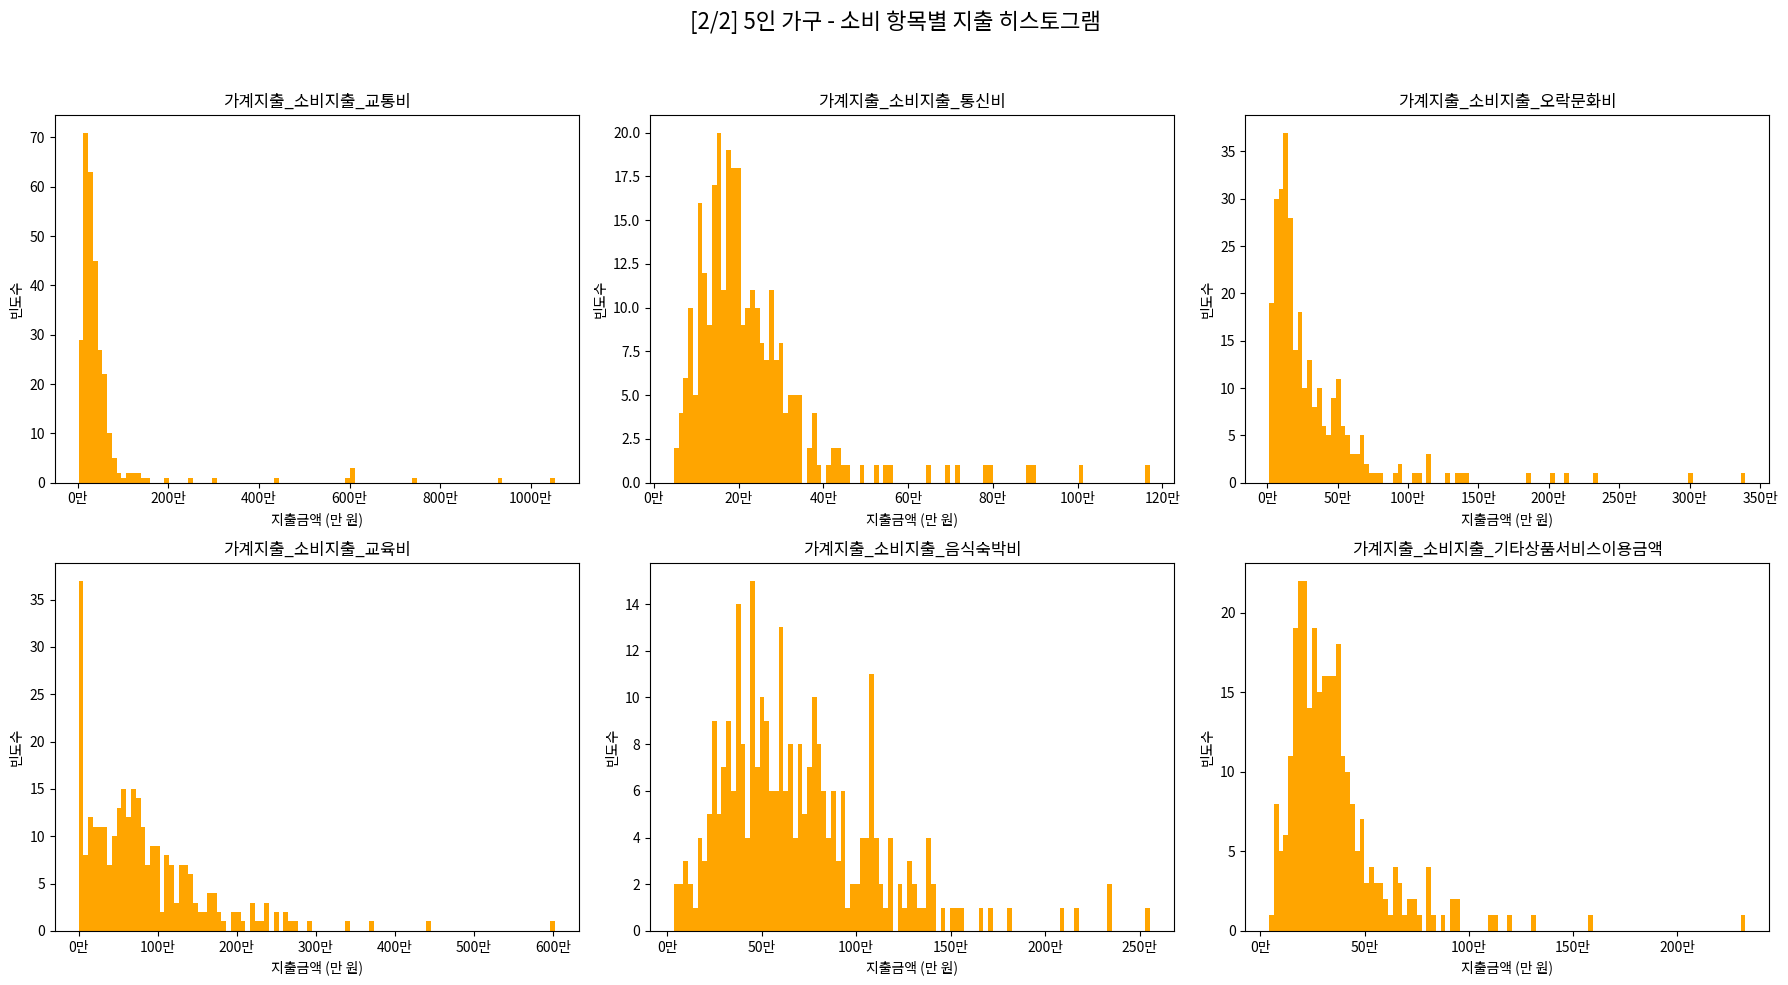

In [20]:
# Histogram

# 데이터 불러오기
dataset = pd.read_excel("final_dataset.xlsx")

# 소비 항목 리스트
item_columns = [
    '가계지출_소비지출_식료품비주류음료구입비',
    '가계지출_소비지출_주류담배구입비',
    '가계지출_소비지출_의류신발구입비',
    '가계지출_소비지출_주거수도광열비',
    '가계지출_소비지출_가정용품가사서비스이용금액',
    '가계지출_소비지출_보건제품구입비',
    '가계지출_소비지출_교통비',
    '가계지출_소비지출_통신비',
    '가계지출_소비지출_오락문화비',
    '가계지출_소비지출_교육비',
    '가계지출_소비지출_음식숙박비',
    '가계지출_소비지출_기타상품서비스이용금액'
]

# 전체 가구원수에 대해 하면 histogram이 너무 많아지니 대략적으로 알 수 있게 1, 3, 5인으로만 진행. -> 모두 right-skewed의 성질을 가지는 것을 알 수 있음.
target_sizes = [1, 3, 5]


for size in target_sizes:
    subset = dataset[dataset['가구원수'] == size]

    # 첫 번째 6개 항목
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
    axes1 = axes1.flatten()
    for i, col in enumerate(item_columns[:6]):
        axes1[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes1[i].set_title(col)
        axes1[i].set_xlabel("지출금액 (만 원)")
        axes1[i].set_ylabel("빈도수")
        axes1[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[1/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 두 번째 6개 항목
    fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
    axes2 = axes2.flatten()
    for i, col in enumerate(item_columns[6:]):
        axes2[i].hist(subset[col].dropna(), bins=100, color='orange')
        axes2[i].set_title(col)
        axes2[i].set_xlabel("지출금액 (만 원)")
        axes2[i].set_ylabel("빈도수")
        axes2[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x // 10000)}만'))
    plt.suptitle(f"[2/2] {size}인 가구 - 소비 항목별 지출 히스토그램", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [21]:
# 가구원수별로 각 항목당 outlier 몇개 있는지 알아보는 코드.
# 결과 저장
outlier_summary = []

# 각 가구원수에 대해
for size, group in dataset.groupby('가구원수'):
    for col in item_columns:
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = group[(group[col] < lower) | (group[col] > upper)]
        outlier_summary.append({
            '가구원수': int(size),
            '항목': col,
            '이상치수': len(outliers),
            '총샘플수': len(group),
            '비율(%)': round(len(outliers) / len(group) * 100, 2)
        })

# 데이터프레임 변환
outlier_df = pd.DataFrame(outlier_summary)

# 정렬
outlier_df = outlier_df.sort_values(by=['가구원수', '이상치수'], ascending=[True, False])

# csv 파일로 저장.
outlier_df.to_csv('outlier_df.csv')

In [23]:
# outlier 처리
# 가구원수별로 그룹핑하고 너무 극단적으로 큰 값은 clipping 해주고, 전체에 log scaling. (log scaling은 그룹별로 안 해줘도 결과 똑같음.)
# Step 1: 가구원수별로 99.5% quantile 기준으로 clip
for col in item_columns:
    for size, group in dataset.groupby('가구원수'):
        threshold = group[col].quantile(0.995)
        mask = dataset['가구원수'] == size
        clipped_values = dataset.loc[mask, col].clip(upper=threshold)
        dataset.loc[mask, col] = clipped_values.astype(dataset[col].dtype)

# Step 2: log1p 변환해서 "_log" 컬럼 추가
for col in item_columns:
    dataset[col + '_log'] = np.log1p(dataset[col])

# csv 파일로 저장.
dataset.to_csv('after_log_df.csv')

# 결과와 확인하기 위해 12가지 소비 품목의 max값 각각 출력해보기.
print(dataset[item_columns].max())


# Feature creation
# 가구원수가 다르면 소비 금액이 달라지는 게 당연하므로, 소비 품목 / 소비지출로 비율 구해서 새로운 열로 추가.
# 총 소비지출금액
total_column = '가계지출_소비지출금액'

# 각 항목의 비율 계산
for col in item_columns:
    ratio_col = col + '_비율'
    dataset[ratio_col] = dataset[col] / (dataset[total_column] + 1e-5)  # 0 나누기 방지용 작은 수 추가

dataset.to_csv('ratio.csv')

가계지출_소비지출_식료품비주류음료구입비      1.544806e+06
가계지출_소비지출_주류담배구입비          3.040940e+05
가계지출_소비지출_의류신발구입비          1.336581e+06
가계지출_소비지출_주거수도광열비          2.208587e+06
가계지출_소비지출_가정용품가사서비스이용금액    2.223189e+06
가계지출_소비지출_보건제품구입비          3.222661e+06
가계지출_소비지출_교통비              9.606507e+06
가계지출_소비지출_통신비              9.288906e+05
가계지출_소비지출_오락문화비            2.513521e+06
가계지출_소비지출_교육비              3.918302e+06
가계지출_소비지출_음식숙박비            2.414239e+06
가계지출_소비지출_기타상품서비스이용금액      2.364405e+06
dtype: float64


# Encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. 산업 코드 대분류 그룹화 함수 정의
def map_industry_group(code):
    if code in ['A']:
        return '1차산업'
    elif code in ['B', 'C', 'D', 'E', 'F']:
        return '제조건설업'
    elif code in ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']:
        return '서비스업'
    elif code in ['O', 'P', 'Q']:
        return '공공/교육/보건'
    else:
        return '기타'

dataset['산업_대분류'] = dataset['가구주_10차산업분류코드'].map(map_industry_group)

# 1. 인코딩할 범주형 컬럼 지정
categorical_features = [
    '가구구분코드',
    '가구주_취업여부',
    '거처구분코드',
    '입주형태코드',
    '산업_대분류'  # ← 앞서 그룹화한 것
]

# 2. 인코더 설정. 다중공선성을 제거하기 위해 기준값 하나 제거.
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# 3. 변환 실행
encoded_array = ohe.fit_transform(dataset[categorical_features])

# 4. 인코딩된 feature 이름 가져오기
encoded_feature_names = ohe.get_feature_names_out(categorical_features)

# 5. DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names, index=dataset.index)

# 6. 원래 dataset에서 범주형 열 제거 후 인코딩된 열 붙이기
dataset = pd.concat([dataset.drop(columns=categorical_features), encoded_df], axis=1)

# 결과 확인
dataset.to_csv('after_encoded.csv')